# Aim 1

## おまじないパート

In [1]:
import sys
from pathlib import Path

# 現在のノートブックのパスを取得
notebook_dir = Path().resolve() 

# プロジェクトルートディレクトリ（notebooksディレクトリの親ディレクトリ）を取得
# プロジェクトルートは2階層上です
project_root = notebook_dir.parent.parent

# プロジェクトルートをPythonの検索パスに追加
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [2]:
from groom import GroomAim1, GroomAim1LinearTests,\
    save_to_parquet, load_from_parquet, save_model, load_model

In [3]:
self = GroomAim1()

In [4]:
import pandas as pd

## BLと毛繕い行動との間に有意差があるか

### delta_dfの読み込み

In [5]:
raw_delta_df = load_from_parquet("../../data/02_preprocessed_data/temperature_delta_df.parquet")

--- 復元完了 ---
復元されたDataFrameのshape: (2625, 17)


### 初期300秒に限定

In [6]:
delta_df = raw_delta_df[(raw_delta_df['delta_time'] <= 300)].copy()

### 散布図の作成

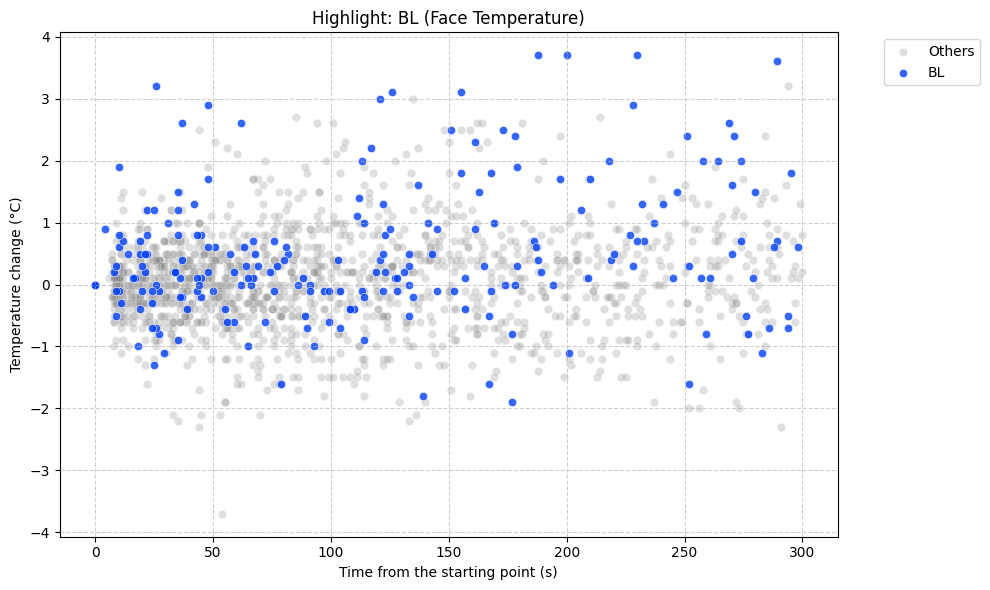

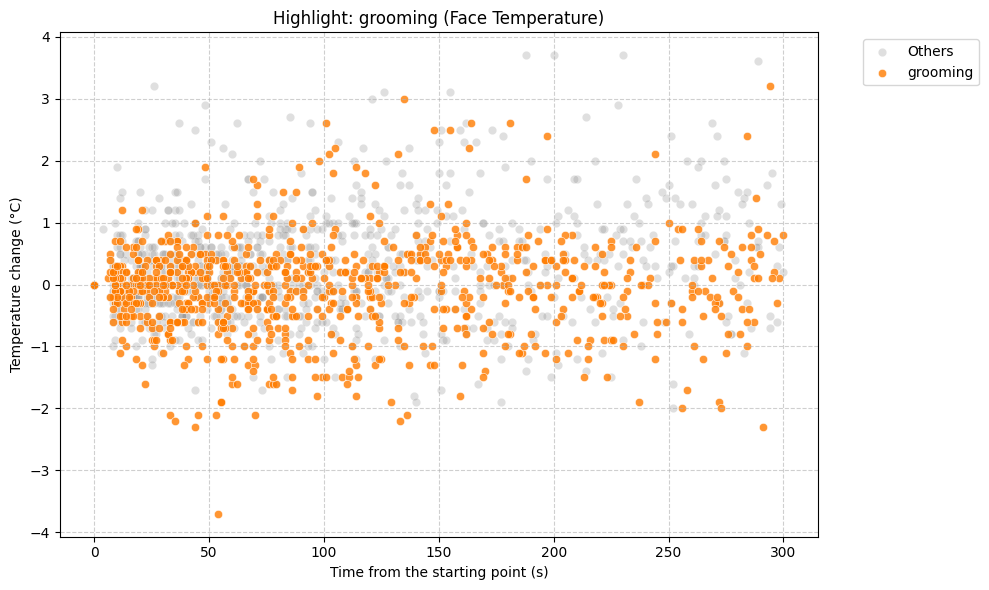

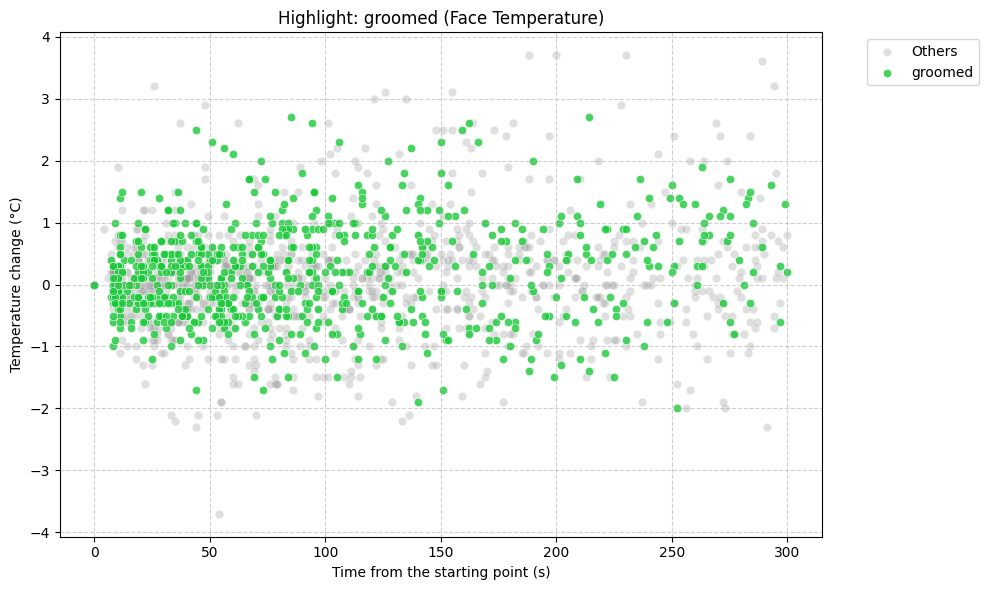

In [7]:
for behavior in delta_df['behavior'].unique():
    self.plot_highlight_behavior(delta_df, target_behavior=behavior, y_column='delta_face')

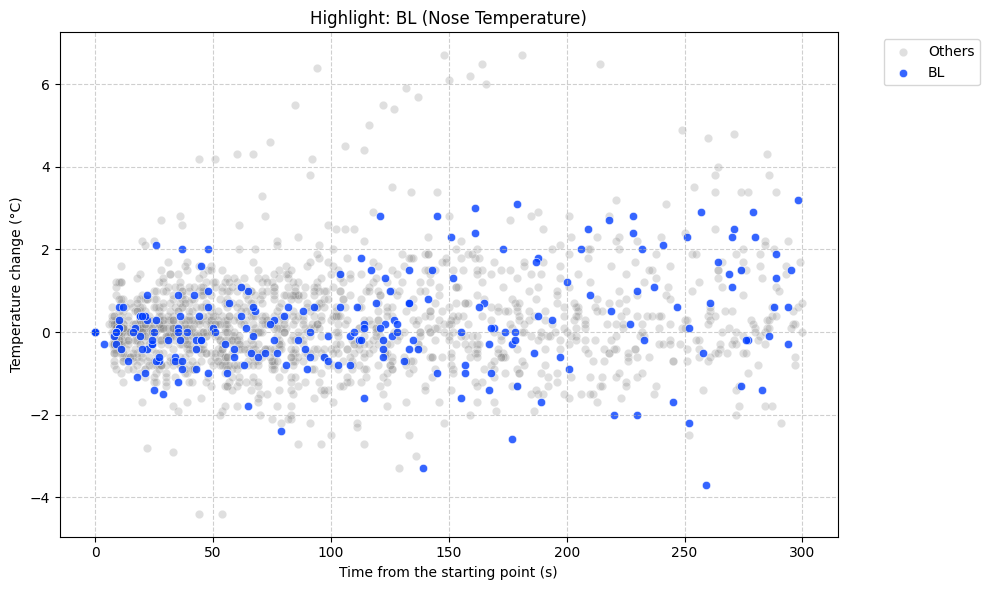

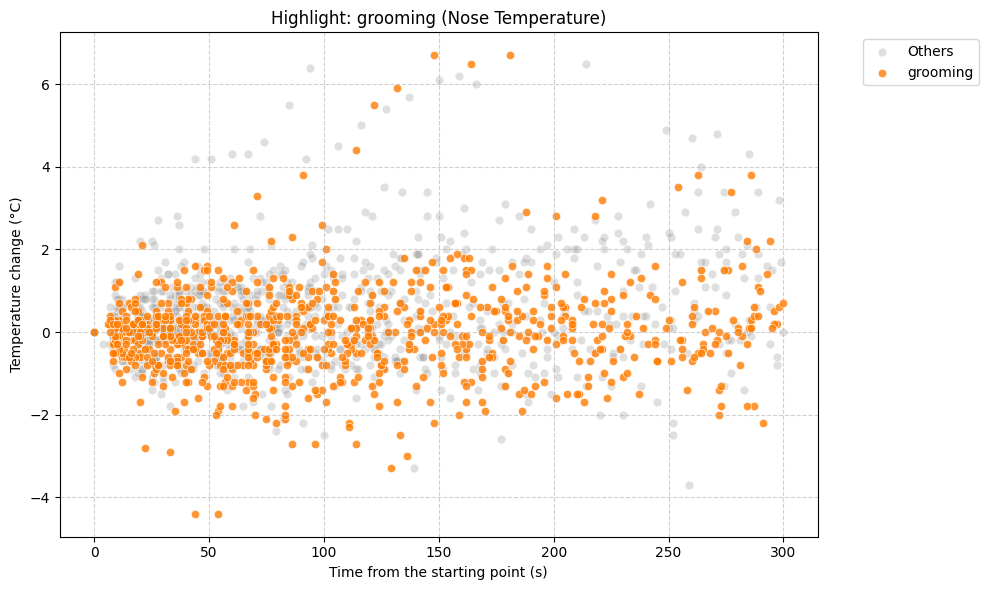

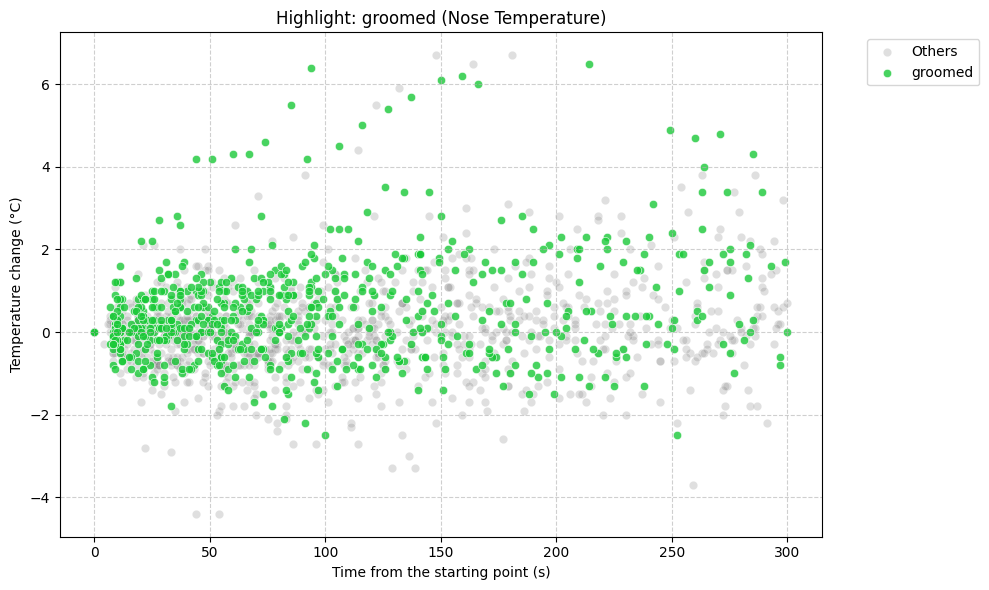

In [8]:
for behavior in delta_df['behavior'].unique():
    self.plot_highlight_behavior(delta_df, target_behavior=behavior, y_column='delta_nose')

### 平滑化トレンドのプロット

まずは1秒間隔のdfを作成

In [9]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

In [10]:
# 1. 内挿実行（一度だけでOK）
delta_df_1s = self.interpolate_samples(delta_df)

Interpolating 267 samples...
Interpolation completed.


In [11]:
print(delta_df_1s.shape)

(80367, 17)


In [12]:
print(delta_df_1s[delta_df_1s['sampling_id'] == 1].shape)

(301, 17)


csvで保存しておく

In [13]:
import pandas as pd
import os

def save_to_csv(df: pd.DataFrame, filename: str):
    """
    DataFrameをCSVファイルとして特定のディレクトリに保存します。
    """
    # 保存先のディレクトリパス
    save_dir = "../../data/03_aim_1_data/"
    
    # ディレクトリが存在しない場合は作成
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"ディレクトリを作成しました: {save_dir}")
    
    # フルパスの構築
    full_path = os.path.join(save_dir, filename)
    
    # CSVとして保存（インデックスを含めるかどうかは用途に合わせて index=False で調整してください）
    delta_df.to_csv(full_path, index=False, encoding='utf-8-sig')
    
    print(f"--- CSV保存完了 ---")
    print(f"Path: {full_path}")
    print(f"ファイルサイズ: {os.path.getsize(full_path) / 1024:.2f} KB")

In [14]:
save_to_csv(delta_df_1s, 'delta_df_1s.csv')

--- CSV保存完了 ---
Path: ../../data/03_aim_1_data/delta_df_1s.csv
ファイルサイズ: 209.08 KB


In [15]:
print(delta_df_1s.head(10))

   delta_time  sampling_id  t0_flag            datetime  delta_face  \
0           0            1      1.0 2025-04-20 08:48:50        0.00   
1           1            1      1.0 2025-04-20 08:48:50        0.06   
2           2            1      1.0 2025-04-20 08:48:50        0.12   
3           3            1      1.0 2025-04-20 08:48:50        0.18   
4           4            1      1.0 2025-04-20 08:48:50        0.24   
5           5            1      1.0 2025-04-20 08:48:50        0.30   
6           6            1      1.0 2025-04-20 08:48:50        0.36   
7           7            1      1.0 2025-04-20 08:48:50        0.42   
8           8            1      1.0 2025-04-20 08:48:50        0.48   
9           9            1      1.0 2025-04-20 08:48:50        0.54   

   delta_nose    name    id sex behavior    to  from shade   kin  \
0        0.00  Takana  21.0   f       BL  None  None    no  None   
1        0.01  Takana  21.0   f       BL  None  None    no  None   
2        0.02 

#### face

全behaviorでの帯プロット

この帯は95%信頼区間

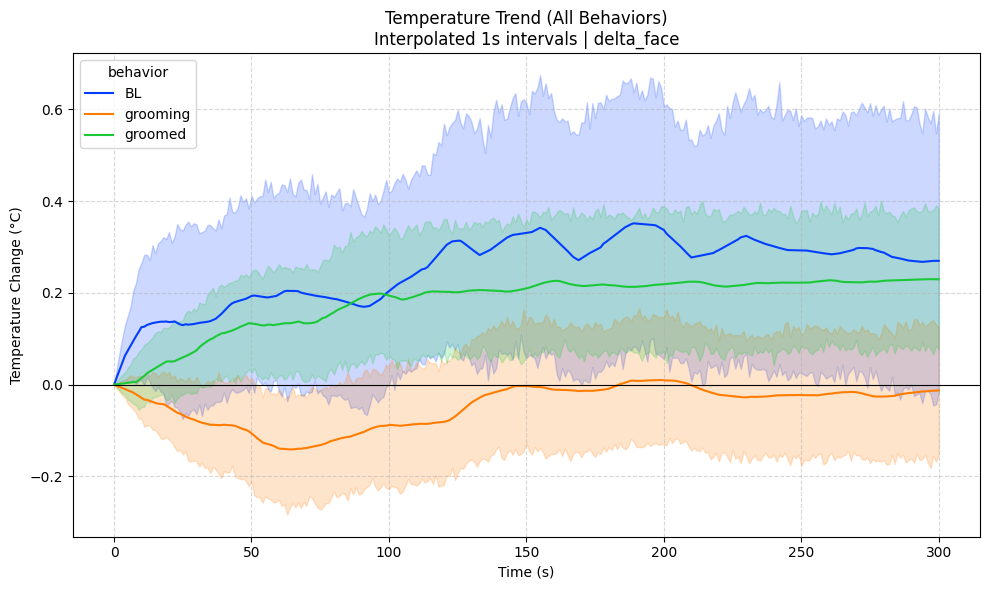

In [16]:
self.plot_smoothed_behavior_comparison(
    delta_df_1s, y_column='delta_face'
)

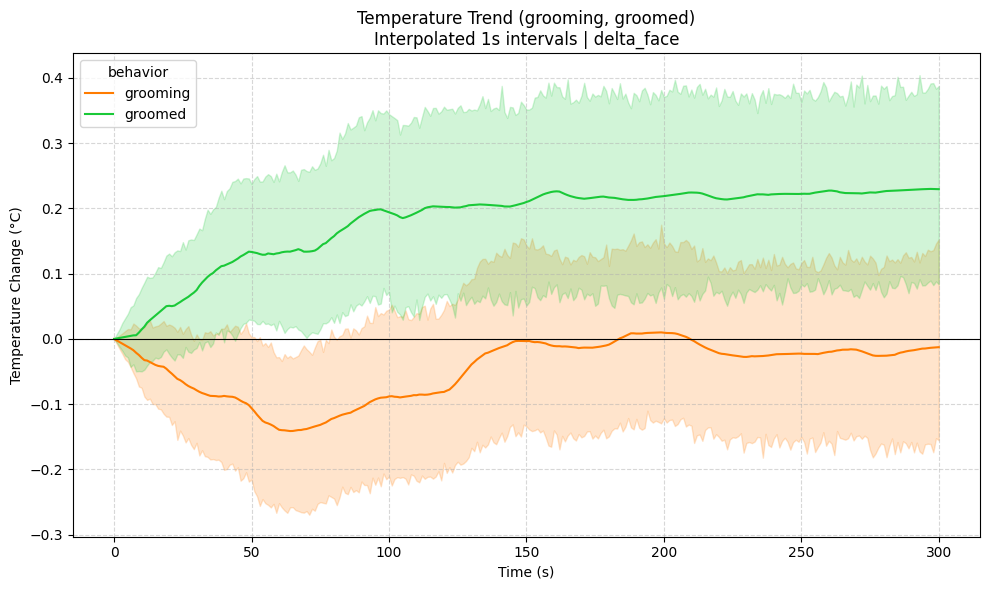

In [17]:
self.plot_smoothed_behavior_comparison(
    delta_df_1s, y_column='delta_face', target_behaviors=['grooming', 'groomed']
)

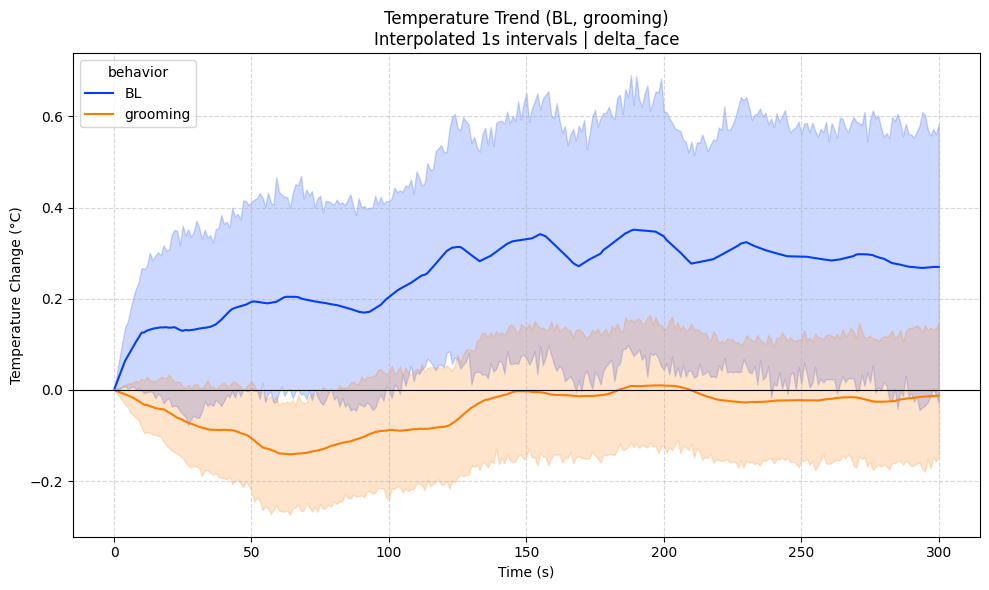

In [18]:
self.plot_smoothed_behavior_comparison(
    delta_df_1s, y_column='delta_face', target_behaviors=['BL', 'grooming']
)

#### nose

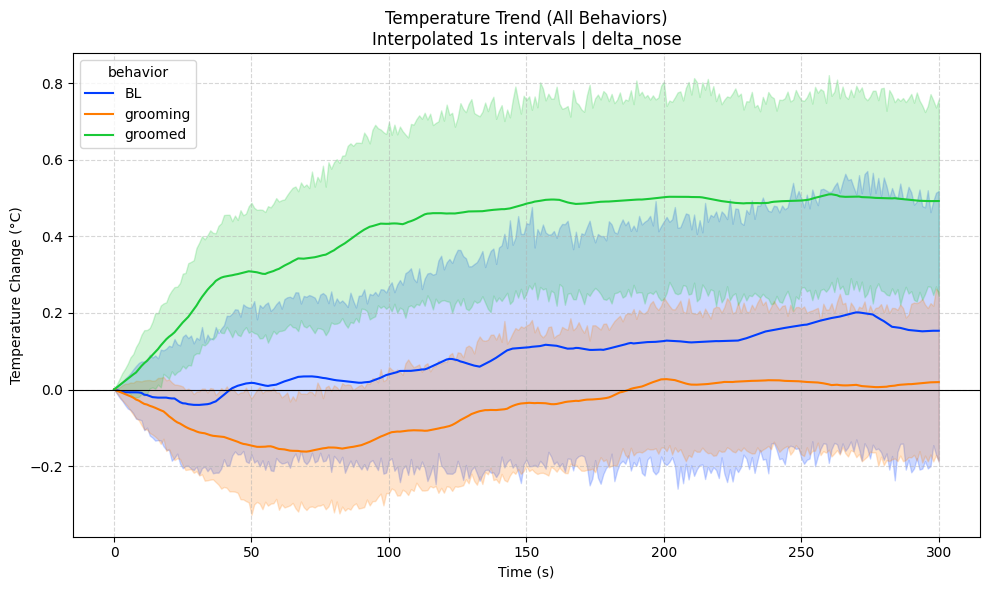

In [19]:
self.plot_smoothed_behavior_comparison(
    delta_df_1s, y_column='delta_nose'
)

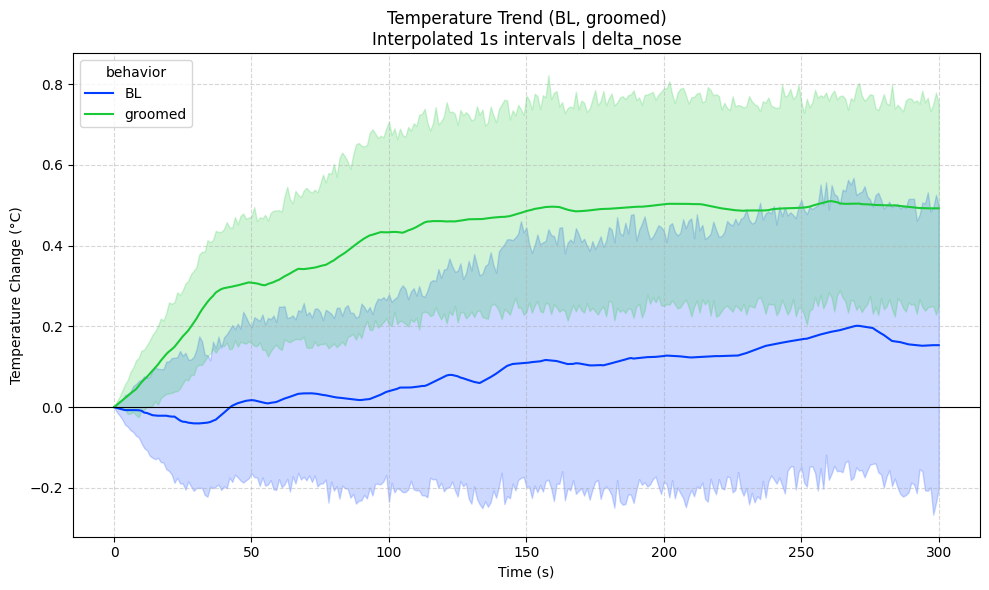

In [20]:
self.plot_smoothed_behavior_comparison(
    delta_df_1s, y_column='delta_nose', target_behaviors=['BL', 'groomed']
)

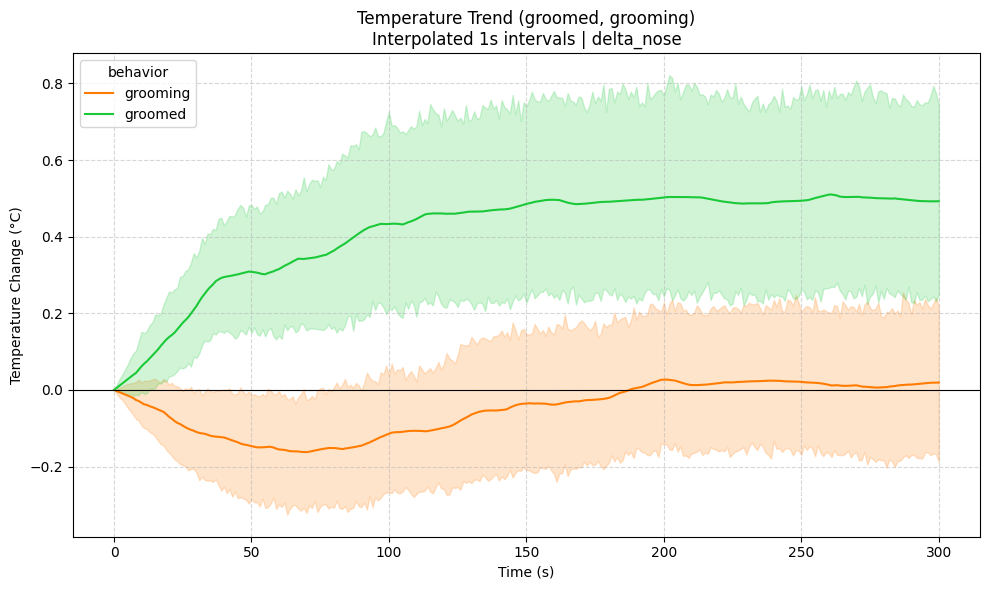

In [21]:
self.plot_smoothed_behavior_comparison(
    delta_df_1s, y_column='delta_nose', target_behaviors=['groomed', 'grooming']
)

### behaviorでの有意差の検証

**クラスターベース置換検定**

1. 1秒ごとに $t$ 検定を行い、$t$ 値を算出します。
2. 有意な $t$ 値（|$t$| > 1.95）が連続している区間を「クラスター」とし、そのクラスター中の $t$ 値の総和（`Cluster Stat`）を計算します
3. 以下を1000回繰り返す
   - 1. `1`の過程
   - 2. `2`の過程
   - 3. `Cluster Stat`の中で最も大きいものを`Max Cluster Stat`として記録する
4. `3`で計算した`Max Cluster Stat`の分布を基に、`3`で計算した実データに基づく`Max Cluster Stat`以上の値が出る確率を計算し、これを$p$値とする

#### face

Running 1000 permutations...

--- Cluster-based Permutation Result: BL vs groomed ---
有意なクラスターは検出されませんでした。
---------------------------------------------------------


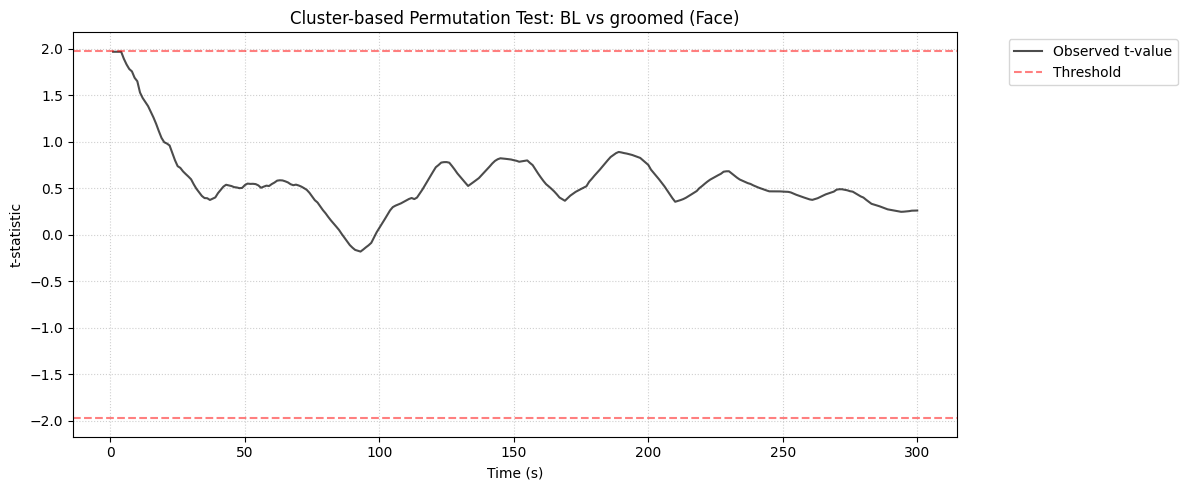

In [22]:
self.run_cluster_permutation_test(
    delta_df_1s, 
    target_behaviors=['BL', 'groomed'],
    y_column='delta_face', 
)

Running 1000 permutations...

--- Cluster-based Permutation Result: BL vs grooming ---
Cluster 1: 1s - 166s | Stat: 399.94 | p = 0.0140
  => ★ 有意 (p < 0.05)
Cluster 2: 171s - 283s | Stat: 245.76 | p = 0.0270
  => ★ 有意 (p < 0.05)
---------------------------------------------------------


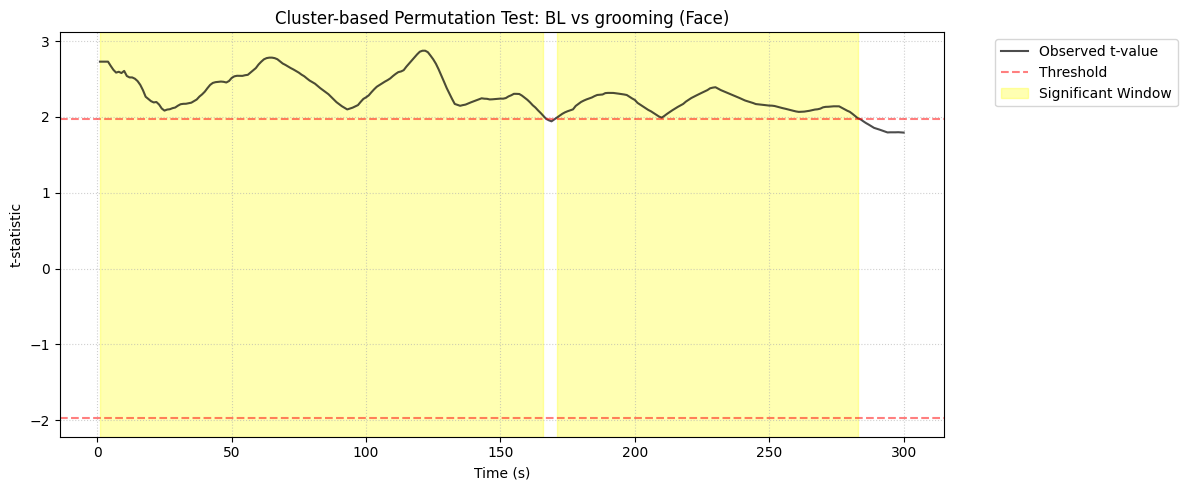

In [23]:
self.run_cluster_permutation_test(
    delta_df_1s, 
    target_behaviors=['BL', 'grooming'],
    y_column='delta_face', 
)

Running 1000 permutations...

--- Cluster-based Permutation Result: groomed vs grooming ---
Cluster 1: 24s - 145s | Stat: 334.55 | p = 0.0250
  => ★ 有意 (p < 0.05)
Cluster 2: 147s - 186s | Stat: 84.96 | p = 0.0800
  => 有意差なし
Cluster 3: 198s - 300s | Stat: 234.94 | p = 0.0340
  => ★ 有意 (p < 0.05)
---------------------------------------------------------


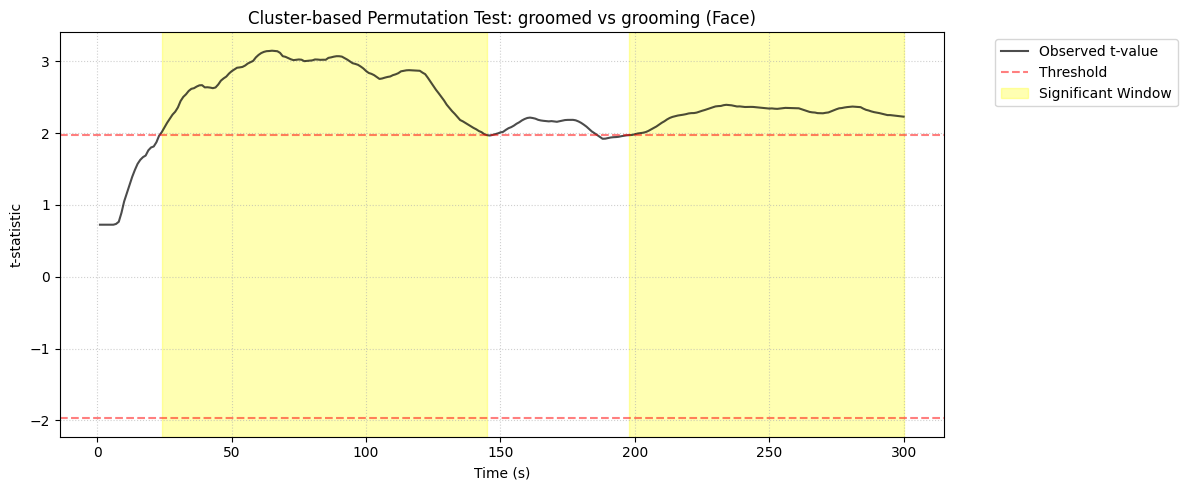

In [24]:
self.run_cluster_permutation_test(
    delta_df_1s, 
    target_behaviors=['groomed', 'grooming'],
    y_column='delta_face', 
)

#### nose

`target_behaviors=['BL', 'groomed']`で見えている程度の小さなクラスター（一瞬しきい値を超える程度の差）であれば、全く無関係なデータを混ぜ合わせて計算しても、約11%の確率で偶然発生してしまう

Running 1000 permutations...

--- Cluster-based Permutation Result: BL vs groomed ---
Cluster 1: 28s - 52s | Stat: 54.83 | p = 0.1100
  => 有意差なし
Cluster 2: 90s - 95s | Stat: 11.94 | p = 0.1730
  => 有意差なし
---------------------------------------------------------


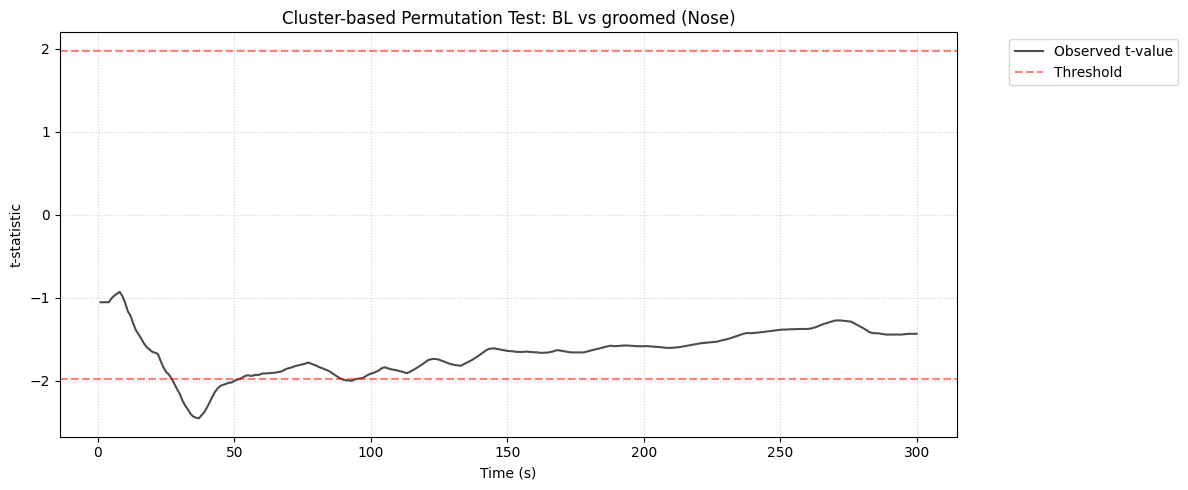

In [25]:
self.run_cluster_permutation_test(
    delta_df_1s, 
    target_behaviors=['BL', 'groomed'],
    y_column='delta_nose', 
)

Running 1000 permutations...

--- Cluster-based Permutation Result: BL vs grooming ---
有意なクラスターは検出されませんでした。
---------------------------------------------------------


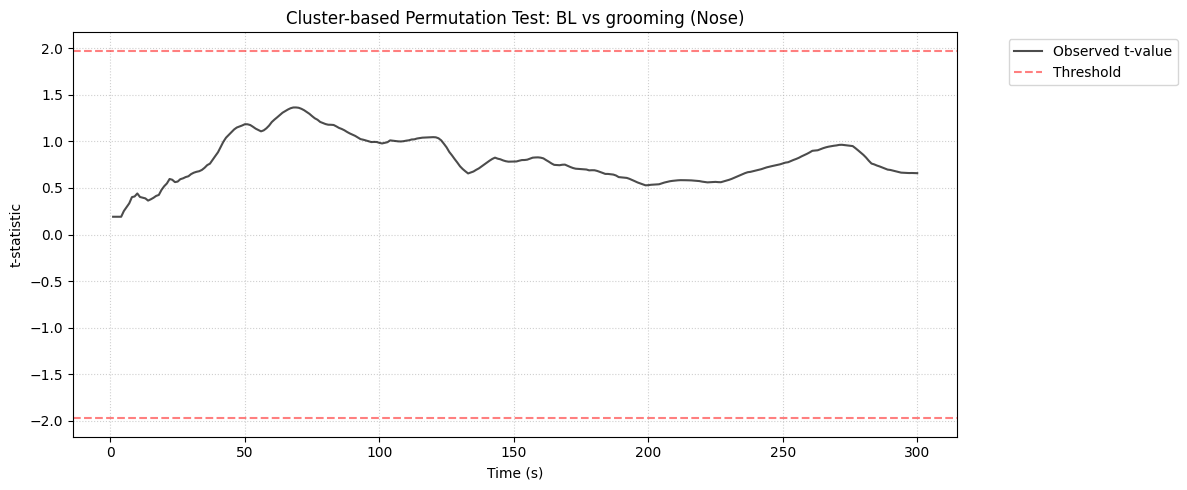

In [26]:
self.run_cluster_permutation_test(
    delta_df_1s, 
    target_behaviors=['BL', 'grooming'],
    y_column='delta_nose', 
)

Running 1000 permutations...

--- Cluster-based Permutation Result: groomed vs grooming ---
Cluster 1: 11s - 300s | Stat: 969.48 | p = 0.0000
  => ★ 有意 (p < 0.05)
---------------------------------------------------------


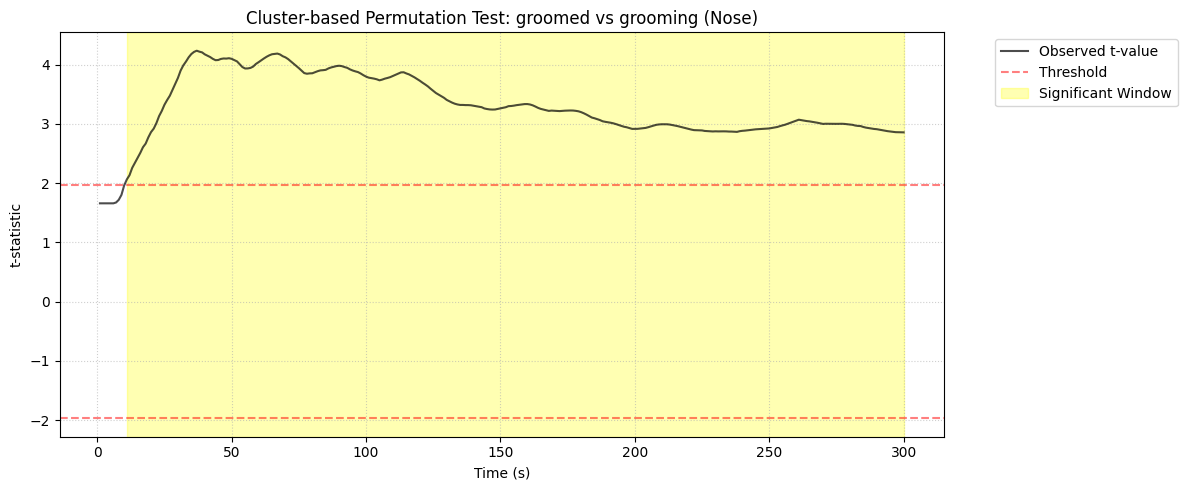

In [27]:
self.run_cluster_permutation_test(
    delta_df_1s, 
    target_behaviors=['groomed', 'grooming'],
    y_column='delta_nose', 
)

## BLでdeltaを補正

### 補正済みの新しいDataFrameを作成

In [28]:
# 1. 補正済みの新しいDataFrameを作成
corrected_delta_df_1s = self.apply_baseline_correction(delta_df_1s)

補正が完了しました。新しく追加された列: ['corrected_delta_nose', 'corrected_delta_face']


### face

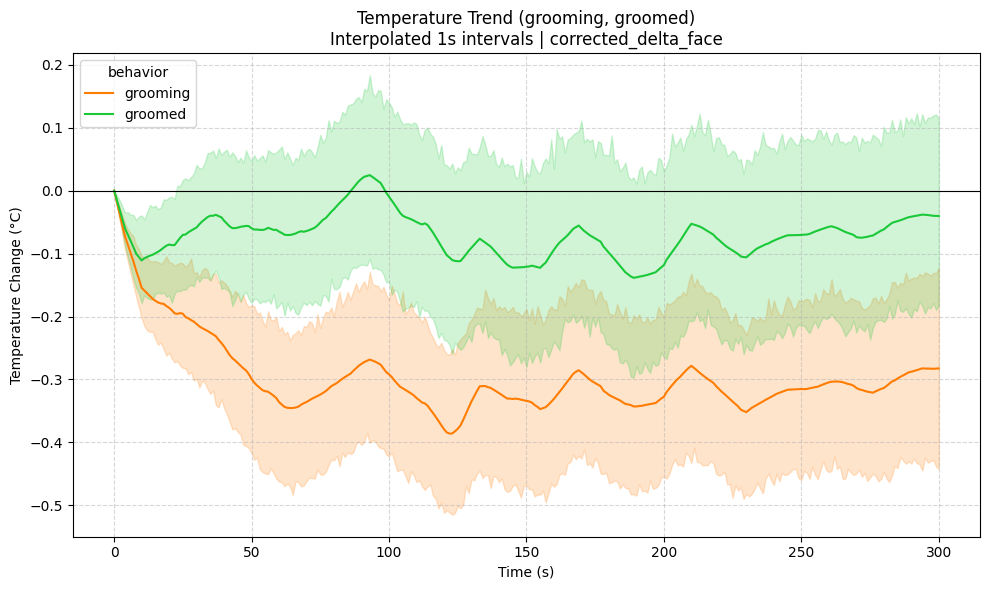

In [29]:
# 2. 補正後の値を使ってプロット
self.plot_smoothed_behavior_comparison(
    corrected_delta_df_1s, 
    y_column='corrected_delta_face',
    target_behaviors=['grooming', 'groomed']
)

Running 1000 permutations...

--- Cluster-based Permutation Result: grooming vs groomed ---
Cluster 1: 24s - 145s | Stat: 334.55 | p = 0.0270
  => ★ 有意 (p < 0.05)
Cluster 2: 147s - 186s | Stat: 84.96 | p = 0.0720
  => 有意差なし
Cluster 3: 198s - 300s | Stat: 234.94 | p = 0.0340
  => ★ 有意 (p < 0.05)
---------------------------------------------------------


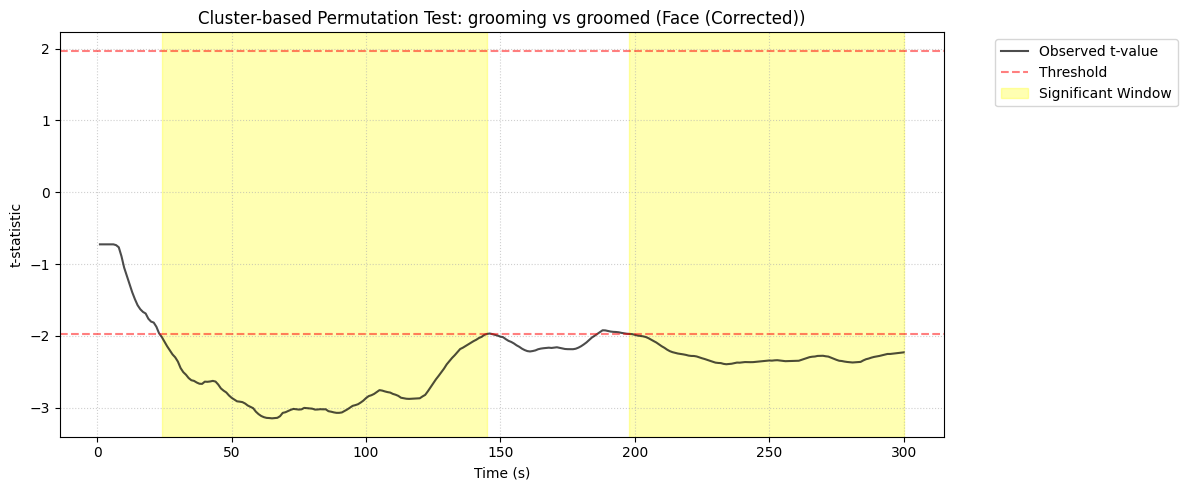

In [30]:
# 3. 補正後の値でクラスターベース置換検定を実行
# 基準が揃っているため、より純粋な行動差を検出しやすくなります
self.run_cluster_permutation_test(
    corrected_delta_df_1s,  
    target_behaviors=['grooming', 'groomed'],
    y_column='corrected_delta_face'
)

### nose

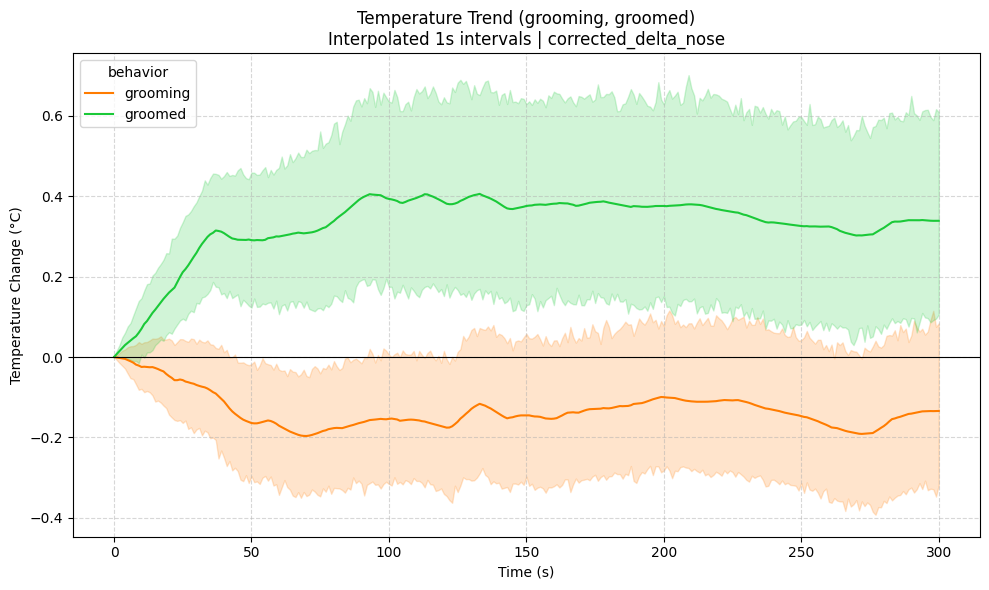

In [31]:
# 2. 補正後の値を使ってプロット
self.plot_smoothed_behavior_comparison(
    corrected_delta_df_1s, 
    y_column='corrected_delta_nose',
    target_behaviors=['grooming', 'groomed']
)

Running 1000 permutations...

--- Cluster-based Permutation Result: grooming vs groomed ---
Cluster 1: 11s - 300s | Stat: 969.48 | p = 0.0000
  => ★ 有意 (p < 0.05)
---------------------------------------------------------


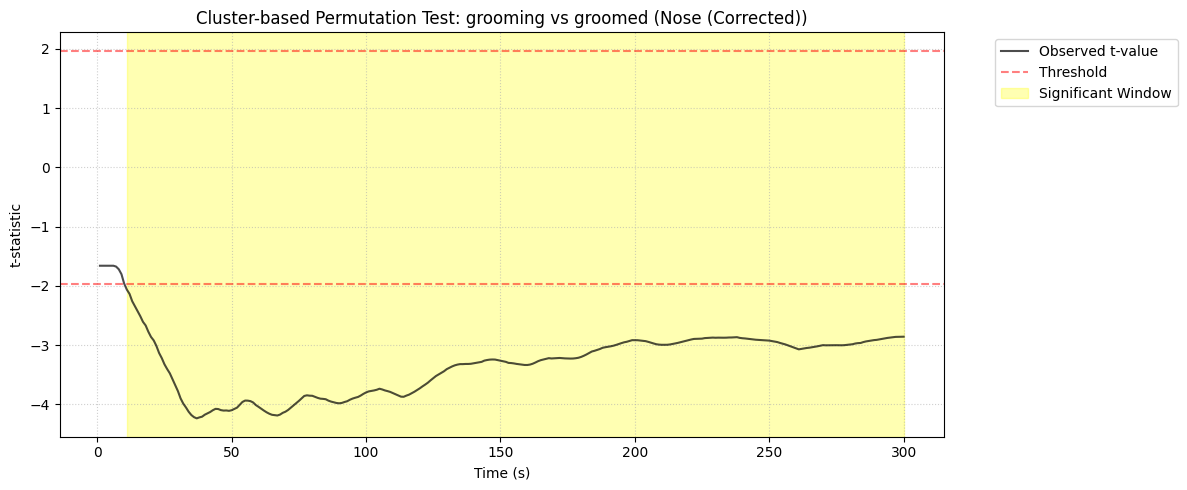

In [32]:
# 3. 補正後の値でクラスターベース置換検定を実行
# 基準が揃っているため、より純粋な行動差を検出しやすくなります
self.run_cluster_permutation_test(
    corrected_delta_df_1s, 
    target_behaviors=['grooming', 'groomed'],
    y_column='corrected_delta_nose'
)

### corrected_delta_df_1sの保存

In [33]:
save_to_parquet(corrected_delta_df_1s, "../../data/03_aim_1_data/corrected_delta_df_1s.parquet")

--- 保存完了 ---
'../../data/03_aim_1_data/corrected_delta_df_1s.parquet' として保存されました。ファイルサイズ: 1378.46 KB


In [34]:
save_to_csv(corrected_delta_df_1s, 'corrected_delta_df_1s.csv')

--- CSV保存完了 ---
Path: ../../data/03_aim_1_data/corrected_delta_df_1s.csv
ファイルサイズ: 209.08 KB


## nose-face

### nose-faceの計算

BL補正前

In [35]:
# 1. 通常の delta_nose - delta_face を計算
nose_face_df = self.calculate_nose_face_difference(corrected_delta_df_1s, use_corrected=False)

計算が完了しました。新しい列: 'nose-face' を作成しました。


BL補正後

In [36]:
# 2. 補正済みの corrected_delta_nose - corrected_delta_face を計算
# (先に apply_baseline_correction を実行している必要があります)
corrected_nose_face_df = self.calculate_nose_face_difference(nose_face_df, use_corrected=True)

計算が完了しました。新しい列: 'corrected_nose-face' を作成しました。


### 帯プロット

#### BL補正前

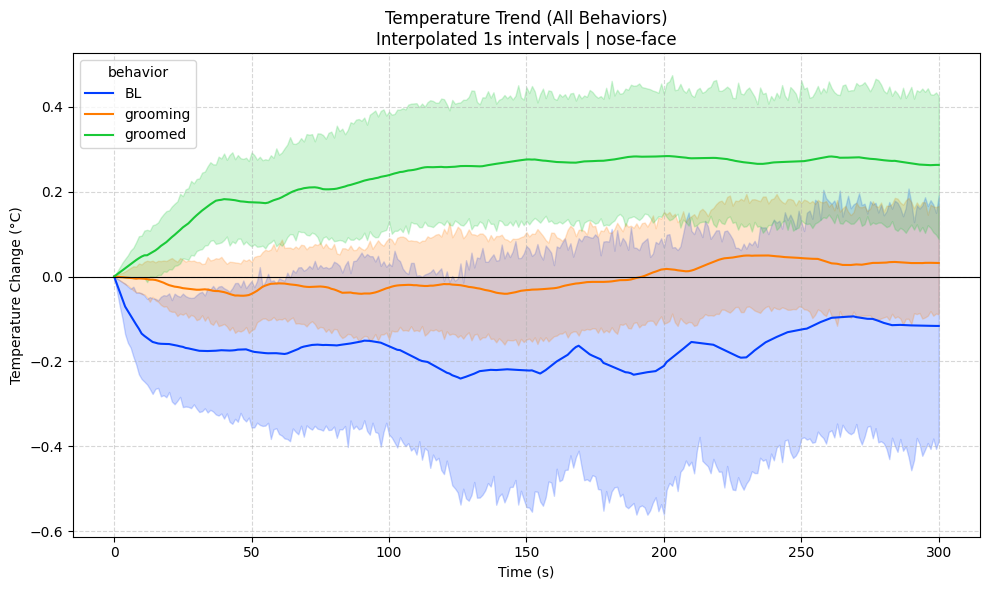

In [37]:
# 3. 作成した列でプロット
self.plot_smoothed_behavior_comparison(
    corrected_nose_face_df, 
    y_column='nose-face'
)

# 結果についてのコメント
# groomedが他の2群に対して有意に温度上昇してそうなことがわかる。
# 多分groomedとgroomingでも有意差がある
# groomingとBLの差はなさそう
# self.run_cluster_permutation_testをすれば確かめれる

#### BL補正後

帯は95%信頼区間なので、これが0に乗ってなかった秒は0より有意に離れていることが示唆される。ただしノイズ的に有意差が出ている可能性があるので、やはりクラスターベース置換検定（1標本検定ver <- New!）でもう一段検定するのが自然

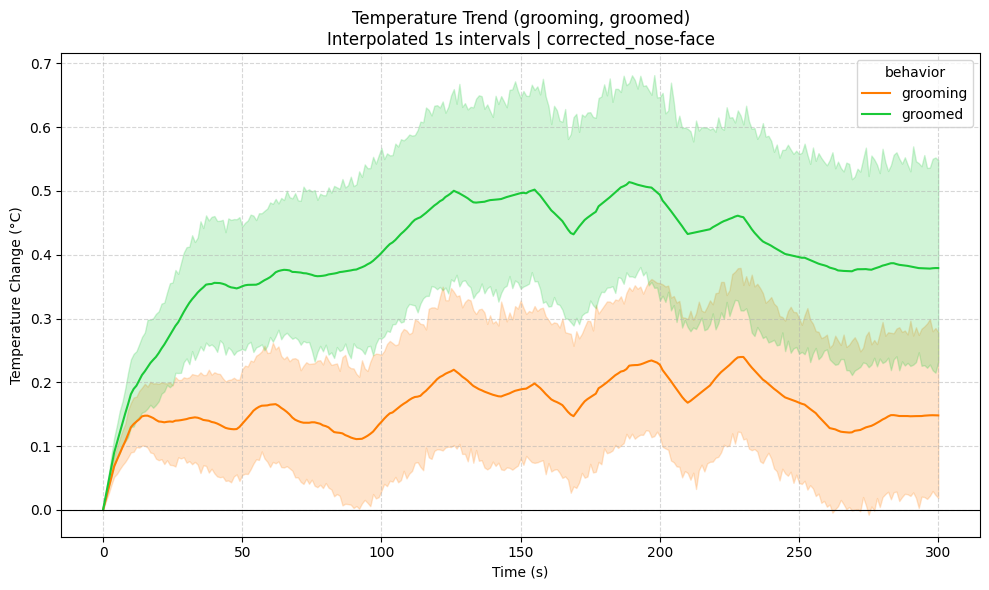

In [38]:
# 3. 作成した列でプロット
self.plot_smoothed_behavior_comparison(
    corrected_nose_face_df, 
    y_column='corrected_nose-face',
    target_behaviors=['grooming', 'groomed']
)

### 補正後nose-faceに対しての検定

#### grooming-groomedでの比較

これは前と同じ2標本クラスターベース置換検定

Running 1000 permutations...

--- Cluster-based Permutation Result: grooming vs groomed ---
Cluster 1: 18s - 300s | Stat: 775.91 | p = 0.0030
  => ★ 有意 (p < 0.05)
---------------------------------------------------------


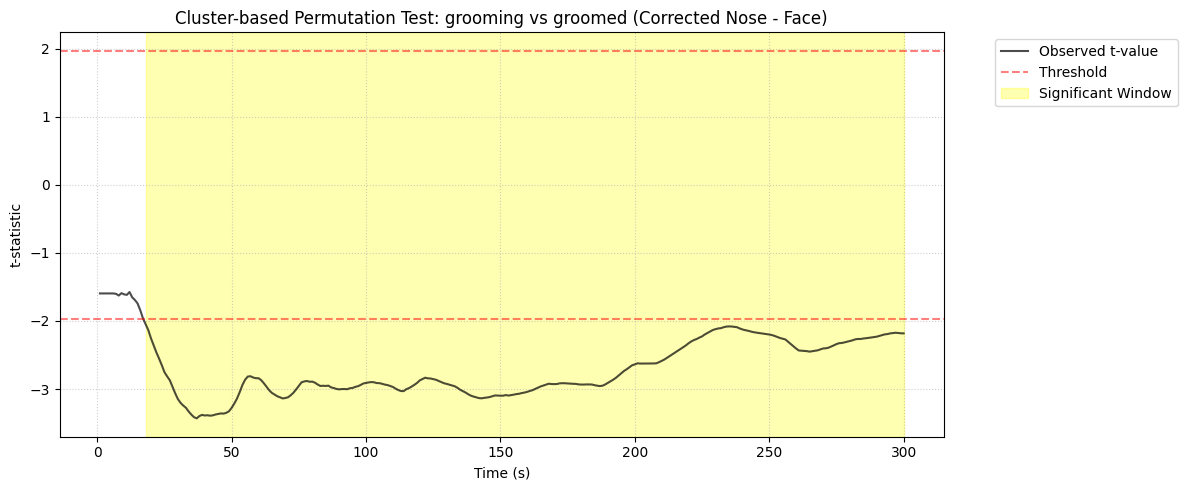

In [39]:
self.run_cluster_permutation_test(
    corrected_nose_face_df,
    target_behaviors=['grooming', 'groomed'],
    y_column='corrected_nose-face'
)

#### groomingでdelta-noseの変化が起きるかどうか

こちらはクラスターベース置換検定（1標本ver）

この関数を使えば、今までの帯プロット全てで0より有意に離れているかどうかが検定できる

`Max Cluster Stat`分布の計算において、2標本ではラベルをシャッフルする方法を取っていたが、今回は現在のsampleに対してランダムに生成した`+1`または`-1`をかけている（もし平均0の帯なら帯が反転対称）

Running 1000 permutations (sign flipping)...

--- One-sample Cluster Test Result: grooming vs 0 ---
Target variable: Corrected Nose - Face
Cluster 1: 1s - 260s | Stat: 877.43 | p = 0.0000
  => ★ 有意 (p < 0.05)
Cluster 2: 277s - 300s | Stat: 51.59 | p = 0.1200
  => 有意差なし
---------------------------------------------------------


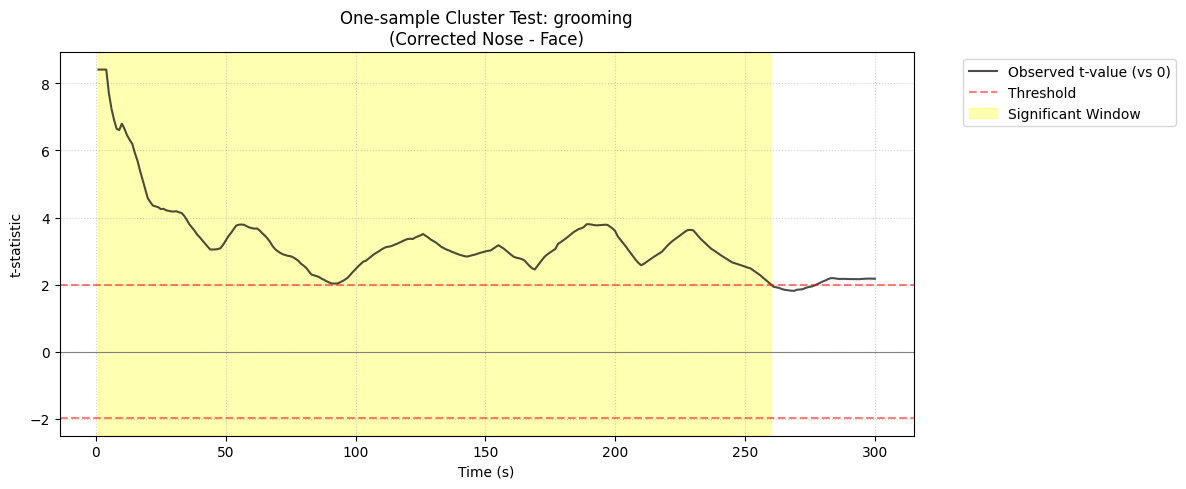

In [40]:
# 補正済みの鼻-顔の温度差が 0 と有意に異なる時間帯を検定
self.run_one_sample_cluster_test(
    corrected_nose_face_df, 
    behavior='grooming', 
    y_column='corrected_nose-face'
)

#### groomedでdelta-noseの変化が起きるかどうか

Running 1000 permutations (sign flipping)...

--- One-sample Cluster Test Result: groomed vs 0 ---
Target variable: Corrected Nose - Face
Cluster 1: 1s - 300s | Stat: 1772.15 | p = 0.0000
  => ★ 有意 (p < 0.05)
---------------------------------------------------------


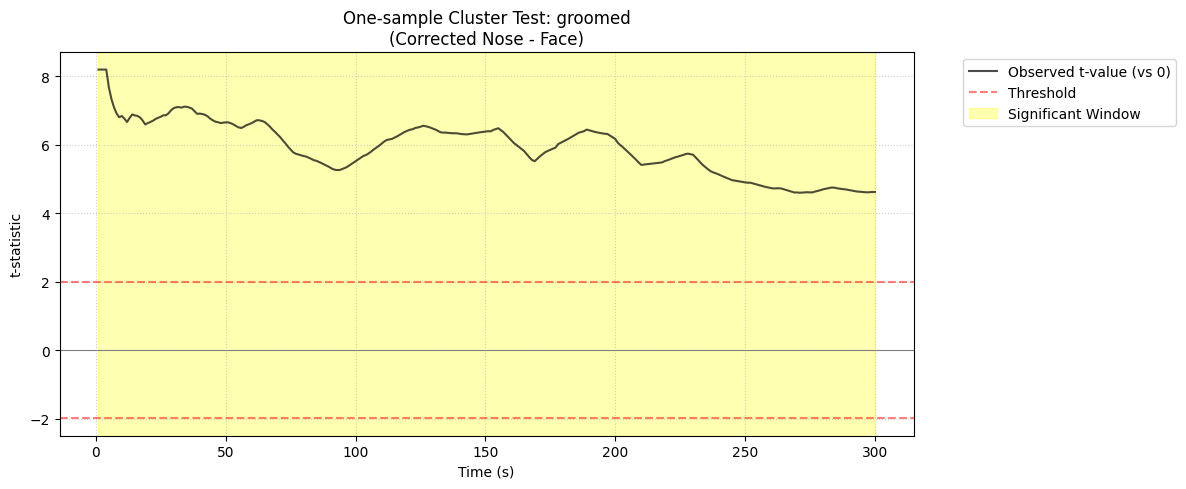

In [41]:
# 補正済みの鼻-顔の温度差が 0 と有意に異なる時間帯を検定
self.run_one_sample_cluster_test(
    corrected_nose_face_df, 
    behavior='groomed', 
    y_column='corrected_nose-face'
)

### `corrected_nose_face_df`の保存

In [42]:
save_to_parquet(
    corrected_nose_face_df, 
    "../../data/03_aim_1_data/corrected_nose_face_df.parquet"
)

--- 保存完了 ---
'../../data/03_aim_1_data/corrected_nose_face_df.parquet' として保存されました。ファイルサイズ: 2114.74 KB


In [43]:
save_to_csv(
    corrected_nose_face_df, 
    'corrected_nose_face_df.csv'
)

--- CSV保存完了 ---
Path: ../../data/03_aim_1_data/corrected_nose_face_df.csv
ファイルサイズ: 209.08 KB


何でか知らないけどExcelだと中身が正しく表示されない <br>
諦めるべし

In [44]:
print(corrected_nose_face_df.columns)

Index(['delta_time', 'sampling_id', 't0_flag', 'datetime', 'delta_face',
       'delta_nose', 'name', 'id', 'sex', 'behavior', 'to', 'from', 'shade',
       'kin', 'is_role_swapped', 'has_Sg', 'shade_condition',
       'corrected_delta_nose', 'corrected_delta_face', 'nose-face',
       'corrected_nose-face'],
      dtype='object')


In [45]:
print(corrected_nose_face_df.head(10))

   delta_time  sampling_id  t0_flag            datetime  delta_face  \
0           0            1      1.0 2025-04-20 08:48:50        0.00   
1           1            1      1.0 2025-04-20 08:48:50        0.06   
2           2            1      1.0 2025-04-20 08:48:50        0.12   
3           3            1      1.0 2025-04-20 08:48:50        0.18   
4           4            1      1.0 2025-04-20 08:48:50        0.24   
5           5            1      1.0 2025-04-20 08:48:50        0.30   
6           6            1      1.0 2025-04-20 08:48:50        0.36   
7           7            1      1.0 2025-04-20 08:48:50        0.42   
8           8            1      1.0 2025-04-20 08:48:50        0.48   
9           9            1      1.0 2025-04-20 08:48:50        0.54   

   delta_nose    name    id sex behavior  ...  from shade   kin  \
0        0.00  Takana  21.0   f       BL  ...  None    no  None   
1        0.01  Takana  21.0   f       BL  ...  None    no  None   
2        0.02  Ta